In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import RidgeClassifier
from sklearn.kernel_approximation import RBFSampler

import time

In [2]:
from lightonml.datasets import FashionMNIST

ImportError: No module named 'lightonml'

In [3]:
# import os

# os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Loading the data

In [2]:
# (train_data, train_labels), (test_data, test_labels) = FashionMNIST()

train_data = np.load('../datasets/export/fashion_mnist/numpy/train_data_fashion_mnist.npy').astype('uint8')
test_data = np.load('../datasets/export/fashion_mnist/numpy/test_data_fashion_mnist.npy').astype('uint8')
train_labels = np.load('../datasets/export/fashion_mnist/numpy/train_targets_fashion_mnist.npy').astype('uint8')
test_labels = np.load('../datasets/export/fashion_mnist/numpy/test_targets_fashion_mnist.npy').astype('uint8')

# Convert one-hot to integers
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

D = train_data[0].reshape(-1).shape[0]

# Flatten the images
train_data = train_data.reshape(-1, D)
test_data = test_data.reshape(-1, D)

## Quick inspection

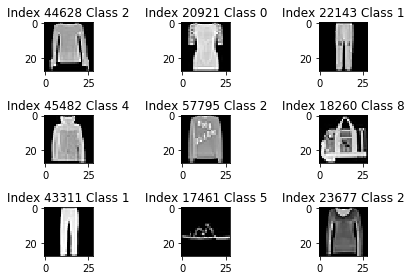

In [4]:
# random check with nine training examples
indices = list(np.random.randint(len(train_data),size=9))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_data[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], train_labels[indices[i]]))
    plt.tight_layout()

In [ ]:
# Labels:
# 0 T-shirt/top
# 1 Trouser
# 2 Pullover
# 3 Dress
# 4 Coat
# 5 Sandal
# 6 Shirt
# 7 Sneaker
# 8 Bag
# 9 Ankle boot

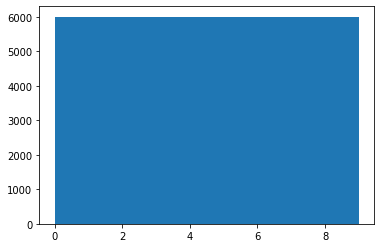

In [107]:
# Train label distribution
plt.hist(train_labels)
plt.show()

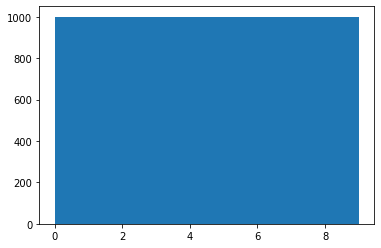

In [108]:
# Test label distribution
plt.hist(test_labels)
plt.show()

## Preprocessing

In [3]:
def threshold_binarize(data, threshold):
    data_bin = np.where(data>threshold, 1, 0).astype('uint8')
    return data_bin

In [4]:
# fashion mnist has values between 0 and 255
threshold = 10

train_data_bin = threshold_binarize(train_data, threshold)
test_data_bin = threshold_binarize(test_data, threshold)

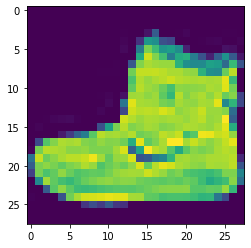

In [120]:
# Original
plt.imshow(train_data.reshape(-1,28,28)[0])

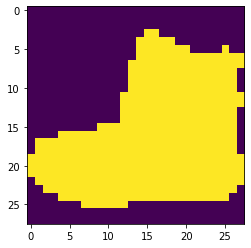

In [121]:
# Threshold binarized
plt.imshow(train_data_bin.reshape(-1,28,28)[0])

## Ridge Classifier

In [129]:
# Without binarization

clf = RidgeClassifier(alpha=1.0)
clf.fit(train_data, train_labels)
clf.score(test_data, test_labels)

/home/jonas/anaconda3/envs/deep_avx/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.69134e-09): result may not be accurate.
  overwrite_a=True).T


0.8113

In [124]:
threshold_values = [i * 10 for i in range(26)]

for t in threshold_values:
    clf = RidgeClassifier(alpha=1.0)
    train_data_bin = threshold_binarize(train_data, t)
    test_data_bin = threshold_binarize(test_data, t)
    clf.fit(train_data_bin, train_labels)
    train_score = clf.score(train_data_bin, train_labels)
    test_score = clf.score(test_data_bin, test_labels)
    
    print('Treshold:', t, 'Train-Score:', train_score, 'Test-Score:', test_score)

Treshold: 0 Train-Score: 0.82665 Test-Score: 0.812
Treshold: 10 Train-Score: 0.8341166666666666 Test-Score: 0.8168
Treshold: 20 Train-Score: 0.8316 Test-Score: 0.8168
Treshold: 30 Train-Score: 0.8291333333333334 Test-Score: 0.8161
Treshold: 40 Train-Score: 0.82685 Test-Score: 0.8095
Treshold: 50 Train-Score: 0.824 Test-Score: 0.8052
Treshold: 60 Train-Score: 0.81935 Test-Score: 0.8004
Treshold: 70 Train-Score: 0.81515 Test-Score: 0.7975
Treshold: 80 Train-Score: 0.8104833333333333 Test-Score: 0.7888
Treshold: 90 Train-Score: 0.8049833333333334 Test-Score: 0.7862
Treshold: 100 Train-Score: 0.7998666666666666 Test-Score: 0.7774
Treshold: 110 Train-Score: 0.7909666666666667 Test-Score: 0.7709
Treshold: 120 Train-Score: 0.7832 Test-Score: 0.7631
Treshold: 130 Train-Score: 0.7743666666666666 Test-Score: 0.7564
Treshold: 140 Train-Score: 0.7637 Test-Score: 0.7432
Treshold: 150 Train-Score: 0.75075 Test-Score: 0.7327
Treshold: 160 Train-Score: 0.73555 Test-Score: 0.7203
Treshold: 170 Train-Sc

<div class="alert alert-block alert-info">
Interestingly, low thresholds lead to the highest scores. I.e. keeping the rough shape leads to better recognition than preserving some of the texture (higher threshold). Hence, we will stick to $t=10$.
    
In general, binarization does not degrade performance on this dataset.
</div>

### Short notes about data types
Only float32 and float64 work well with numpy and BLAS to exploit parallelization for matrix computations:
https://stackoverflow.com/questions/35101312/multi-threaded-integer-matrix-multiplication-in-numpy-scipy

In [10]:
train_data_bin = threshold_binarize(train_data, 10)
test_data_bin = threshold_binarize(test_data, 10)
# we need to work with flot32 or float64 for some reason.
# otherwise numpy freezes
all_data = np.vstack([train_data_bin, test_data_bin]).astype('float32')

In [6]:
import synthetic_opu

In [11]:
data_proj = synthetic_opu.project_big_np_matrix(all_data, out_dim=100000, chunk_size=5000, projection='opu',
                          framework='pytorch', dtype=torch.FloatTensor, cuda=True)

Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Total time elapsed (seconds): 142.35324335098267
Time per chunk (seconds): 10.168088810784477


In [9]:
data_proj.shape

(70000, 100000)

In [12]:
data_proj[0]

array([240.9174   , 464.87473  , 132.44174  , ..., 134.19063  ,
       143.64777  ,   3.0319245], dtype=float32)

In [21]:
def rbf_fourier_features(data, output_dim, gamma='auto'):
    if gamma == 'auto':
        # same initialization as for the svm in sklearn
        n_features = data.shape[1]
        gamma = 1. / (n_features * data.var())
    sampler = RBFSampler(gamma=gamma, n_components=output_dim, random_state=1)
    return sampler.fit_transform(data)

In [22]:
data_proj = rbf_fourier_features(all_data, output_dim=int(1e4))

In [23]:
data_proj.shape

(70000, 10000)

In [12]:
train_proj = data_proj[:len(train_data_bin)]
test_proj = data_proj[len(train_data_bin):]

In [25]:
# RBF: dim=10K, gamma='auto'
clf = RidgeClassifier(alpha=1.0)
clf.fit(train_proj, train_labels)
clf.score(test_proj, test_labels)

0.8781

In [9]:
# OPU: dim=10K, std_dev=1.0, 64bits
clf = RidgeClassifier(alpha=1.0)
clf.fit(train_proj, train_labels)
clf.score(test_proj, test_labels)

0.8783

In [13]:
# OPU: dim=10K, std_dev=1.0, 32bits
clf = RidgeClassifier(alpha=1.0)
clf.fit(train_proj, train_labels)
clf.score(test_proj, test_labels)

/data/alpha/jonas-wacker/opu-venv/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.92722e-09): result may not be accurate.
  overwrite_a=True).T


0.884

In [ ]:
# OPU: dim=100K, std_dev=0.5, 32bits
since = time.time()

clf = RidgeClassifier(alpha=1.0)
clf.fit(train_proj, train_labels)
score = clf.score(test_proj, test_labels)

elapsed = time.time() - since

print('Score:', score)
print('Time:', elapsed)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


In [ ]:
# TODO: test higher dimensions here!

## Manual Ridge Classifier through Kernel Ridge Regression

Allows for custom kernels!

In [5]:
from sklearn.preprocessing import LabelBinarizer
from kernel_ridge import KernelRidge

In [6]:
# like one-hot encoding with 0 corresponding to -1
label_binarizer = LabelBinarizer(pos_label=1, neg_label=-1)
train_labels_bin = label_binarizer.fit_transform(train_labels)
test_labels_bin = label_binarizer.fit_transform(test_labels)

In [ ]:
# Adapted Kernel Ridge

clf = KernelRidge(alpha=1.0, kernel='polynomial', degree=2, lr=1e-5, epochs=10)
clf.fit(train_data_bin, train_labels_bin) 

Running CG for dim 0
Current coef shape (60000,)
Running CG for dim 1
Current coef shape (60000,)
Running CG for dim 2
Current coef shape (60000,)
Running CG for dim 3
Current coef shape (60000,)
Running CG for dim 4
Current coef shape (60000,)
Running CG for dim 5
Current coef shape (60000,)
Running CG for dim 6
Current coef shape (60000,)
Running CG for dim 7


In [13]:
# Adapted Kernel Ridge

clf = KernelRidge(alpha=1.0, kernel='polynomial', degree=2, lr=1e-5, epochs=10)
clf.fit(train_data_bin, train_labels_bin) 

Epoch: 0 Loss: 1.5723495483398438 Accuracy: 9.375
Epoch: 1 Loss: 0.2759420871734619 Accuracy: 48.4375
Epoch: 2 Loss: 0.2302538901567459 Accuracy: 66.40625
Epoch: 3 Loss: 0.2276086062192917 Accuracy: 68.75
Epoch: 4 Loss: 0.229262113571167 Accuracy: 64.84375
Epoch: 5 Loss: 0.2184719294309616 Accuracy: 63.28125
Epoch: 6 Loss: 0.21663837134838104 Accuracy: 64.0625
Epoch: 7 Loss: 0.22219529747962952 Accuracy: 58.59375
Epoch: 8 Loss: 0.20055703818798065 Accuracy: 67.1875
Epoch: 9 Loss: 0.2320098578929901 Accuracy: 62.5
Epoch: 10 Loss: 0.18858258426189423 Accuracy: 74.21875
Epoch: 11 Loss: 0.1862023025751114 Accuracy: 75.78125
Epoch: 12 Loss: 0.22418515384197235 Accuracy: 70.3125
Epoch: 13 Loss: 0.20683762431144714 Accuracy: 65.625
Epoch: 14 Loss: 0.1956338882446289 Accuracy: 69.53125
Epoch: 15 Loss: 0.19281010329723358 Accuracy: 72.65625
Epoch: 16 Loss: 0.21974103152751923 Accuracy: 69.53125
Epoch: 17 Loss: 0.20620830357074738 Accuracy: 69.53125
Epoch: 18 Loss: 0.18642330169677734 Accuracy: 

In [ ]:
predictions = clf.predict(test_data_bin)

In [ ]:
# scipy cg method
score = np.sum(np.equal(np.argmax(predictions, 1), np.argmax(test_labels_bin, 1))) / len(test_data_bin) * 100
print(score)

In [17]:
# gpu multiple regression (0.1596 squared training loss)
score = np.sum(np.equal(np.argmax(predictions, 1), np.argmax(test_labels_bin, 1))) / len(test_data_bin) * 100
print(score)

73.63


In [ ]:
# Kernel ridge struggles with inversion of N^2 matrix!
# Storing an NxN matrix should require:
# N^2 × 32bits ÷ 8bits ÷ 1024^3 (GB), 13.411 (26.8221) GB if we use float32 (64)

# https://github.com/scikit-learn/scikit-learn/blob/1495f6924/sklearn/linear_model/ridge.py#L586
# describes the kernel inversion method
# it is exactly the same as the one from the 2015 paper

clf = KernelRidge(alpha=1.0, kernel='linear')
clf.fit(train_data_bin, train_labels_bin) 

## SVM

In [ ]:
# Linear SVM (uses LibLinear instead of LibSVM), dim=10K, OPU features

since = time.time()

clf = LinearSVC(C=1.0)
clf.fit(train_proj, train_labels)
score = clf.score(test_proj, test_labels)

elapsed = time.time() - since

print('Score:', score)
print('Time:', elapsed)

In [5]:
# RBF True Kernel (10 minutes)

since = time.time()

clf = SVC(C=1.0, kernel='rbf', degree=3)
clf.fit(train_data_bin, train_labels)
score = clf.score(test_data_bin, test_labels)

elapsed = time.time() - since

print('Score:', score)
print('Time:', elapsed)

/home/jonas/anaconda3/envs/deep_avx/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Score: 0.8598
Time: 746.04407787323
